# Rapidly Exploring Random Tree (RRT) Path Planning

In [1]:
import numpy as np
from dataclasses import dataclass
from scipy.spatial import KDTree
from typing import Optional


@dataclass
class Node:
    state: np.ndarray
    parent: Optional['Node']


def find_nearest_node(nodes: [Node], x_sample: np.ndarray) -> Node:
    """Find the nearest node to x_samp."""
    xs = np.array([node.state for node in nodes])
    tree = KDTree(xs)
    nearest_dist, nearest_ind = tree.query(x_sample)
    return nodes[nearest_ind]


def local_planner(x1: np.ndarray, x2: np.ndarray, illegal_region: np.ndarray) -> Optional[np.ndarray]:
    """Use a local planner to find a transition from x1 to x2."""
    dx = (x2 - x1)
    dxn = dx / np.linalg.norm(dx)
    x_new = x1 + 0.25 * dxn  # Naive transition  

    # Check if the transition is illegal by checking if it is inside the illegal region
    if np.all(illegal_region[0] < x_new) and np.all(x_new < illegal_region[2]):
        return None

    return x_new


def is_goal(x: np.ndarray, x_goal: np.ndarray, tol: float = 0.5) -> bool:
    """Check if x is within tol of x_goal."""
    return np.linalg.norm(x - x_goal) < tol


def rrt(x_start: np.ndarray, x_goal: np.ndarray, illegal_region: np.ndarray) -> [Node]:
    """RRT algorithm. See Lynch and Park (p. 381)."""
    xs = [x_start]
    nodes = [Node(x_start, None)]

    # Add the start node to the tree
    T_max = 300
    while len(xs) < T_max:
        # Sample from the space and find the nearest state to the sample
        # Add bias towards the goal        
        if np.random.uniform(0, 1) < 0.1:
            x_sample = x_goal
        else:
            x_sample = np.array([np.random.uniform(0, 10), np.random.uniform(0, 10)])

        node_nearest = find_nearest_node(nodes, x_sample)

        # Use a local planner to find a transition from x_nearest to x_new
        x_new = local_planner(node_nearest.state, x_sample, illegal_region)
        if x_new is None:
            continue

        nodes.append(Node(x_new, node_nearest))
        xs.append(x_new)

        if is_goal(x_new, x_goal):
            nodes.append(Node(x_goal, nodes[-1]))
            return nodes
    return nodes


x_start = np.array([0., 0.])
x_goal = np.array([10., 10.])
illegal_region = np.array([[3, 3], [3, 5], [5, 5], [5, 3]])
nodes = rrt(x_start, x_goal, illegal_region)


In [2]:
def rrt_to_trajectory(nodes: [Node]) -> Optional[np.ndarray]:
    """Convert the RRT nodes to a trajectory."""
    if not is_goal(nodes[-1].state, x_goal):
        # No path found
        return None
        
    trajectory = [nodes[-1].state]
    parent = nodes[-1].parent
    while parent is not None:
        trajectory.append(parent.state)
        parent = parent.parent
    return np.array(trajectory[::-1])

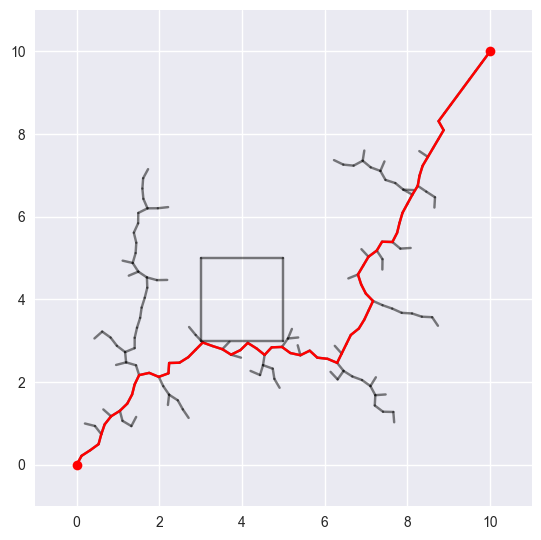

In [3]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

fig, ax = plt.subplots()

# Plot the tree
edges = [(node.state, node.parent.state) for node in nodes if node.parent is not None]
for edge in edges:
    ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], 'k-', alpha=0.5)

# Plot the path
xs = rrt_to_trajectory(nodes)
ax.plot(xs[:, 0], xs[:, 1], 'r-')

# Start and goal
ax.plot(x_start[0], x_start[1], 'ro')
ax.plot(x_goal[0], x_goal[1], 'ro')

# Illegal region
for i in range(4):
    p1 = illegal_region[i]
    p2 = illegal_region[(i + 1) % 4]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', alpha=0.5)

ax.set_xlim([-1, 11])
ax.set_ylim([-1, 11])
ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()



In [4]:
from scipy.interpolate import splprep, splev
tck, u = splprep(xs.T, s=2)
x_new, y_new = splev(np.linspace(0, 1, 100), tck)
xs_new = np.array([x_new, y_new]).T

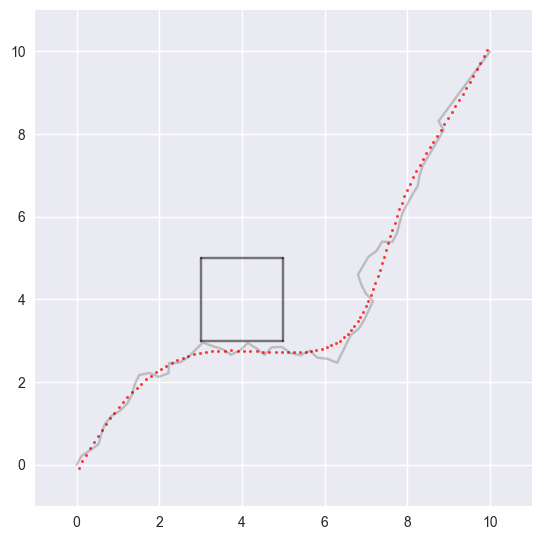

In [5]:
# Plot the splines
fig, ax = plt.subplots()

ax.plot(xs[:, 0], xs[:, 1], 'k-', alpha=0.2)
ax.scatter(x_new, y_new, c='r', s=3, alpha=0.8)

# Illegal region
for i in range(4):
    p1 = illegal_region[i]
    p2 = illegal_region[(i + 1) % 4]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', alpha=0.5)

ax.set_xlim([-1, 11])
ax.set_ylim([-1, 11])
ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

# Model Predictive Control

In [6]:
import numpy as np
import pyomo.environ as pyo
import pyomo.dae as dae

def model(state: np.ndarray, ref: np.ndarray, dt: float = 0.1, l: float = 1.0):
    """Create a model for the MPC problem.
    
    @param state: The initial state of the system (x, y, v, theta)
    @param ref: The x, y reference trajectory
    """
    horizon = ref.shape[0]  # The length of the reference trajectory
    DT = horizon * dt  # The total time of the trajectory
    m = pyo.ConcreteModel()
    m.t = dae.ContinuousSet(bounds=(0, DT))
    
    u_a_max = 3 # 3 m/s^2
    u_omega_max = np.pi / 2 # 90 degrees per second
    m.u_a = pyo.Var(m.t, initialize=0, bounds=(-u_a_max, u_a_max))
    m.u_omega = pyo.Var(m.t, initialize=0, bounds=(-u_omega_max, u_omega_max))
    
    m.x = pyo.Var(m.t)
    m.y = pyo.Var(m.t)
    m.v = pyo.Var(m.t)
    m.theta = pyo.Var(m.t)
    m.dxdt = dae.DerivativeVar(m.x, wrt=m.t)
    m.dydt = dae.DerivativeVar(m.y, wrt=m.t)
    m.dvdt = dae.DerivativeVar(m.v, wrt=m.t)
    m.dthetadt = dae.DerivativeVar(m.theta, wrt=m.t)
    

    # Constraints from dynamics 
    def _dxdt(m, t):
        return m.dxdt[t] == m.v[t] * pyo.cos(m.theta[t])
    m.dxdt_constraint = pyo.Constraint(m.t, rule=_dxdt)
    
    def _dydt(m, t):
        return m.dydt[t] == m.v[t] * pyo.sin(m.theta[t])
    m.dydt_constraint = pyo.Constraint(m.t, rule=_dydt)
    
    def _dvdt(m, t):
        return m.dvdt[t] == m.u_a[t]
    m.dvdt_constraint = pyo.Constraint(m.t, rule=_dvdt)
    
    def _dthetadt(m, t):
        return m.dthetadt[t] == m.v[t] * m.u_omega[t] / l
    m.dthetadt_constraint = pyo.Constraint(m.t, rule=_dthetadt)
    
    # Initial conditions
    m.x[m.t.first()].fix(state[0])
    m.y[m.t.first()].fix(state[1])
    m.v[m.t.first()].fix(state[2])    
    m.theta[m.t.first()].fix(state[3])
    
    def integral(m, t):
        indices = np.arange(len(ref))
        x = np.interp(t / dt, indices, ref[:,0])
        y = np.interp(t / dt, indices, ref[:,1])
        
        return m.u_a[t] ** 2 + m.u_omega[t] ** 2 + 10 * (x - m.x[t])**2 + 10 * (y - m.y[t]) ** 2
    
    m.integral = dae.Integral(m.t, wrt=m.t, rule=integral)    
    m.obj = pyo.Objective(expr=m.integral, sense=pyo.minimize)
    
    return m
    

In [7]:
def get_reference_trajectory(state: np.ndarray, xs: np.ndarray, horizon: int) -> np.ndarray:
    """Get the reference trajectory from xs by finding the point that is closest to the current state"""
    distances = np.linalg.norm(xs - state[:2], axis=1)
    closest_index = np.argmin(distances)
    
    if closest_index + horizon > xs.shape[0]:
        return xs[closest_index:]
    else:
        return xs[closest_index:closest_index + horizon]

In [8]:
current_state = np.array([0, 0, 0, 0])
# Plan a trajectory
nodes = rrt(current_state[:2], x_goal, illegal_region)
xs = rrt_to_trajectory(nodes)

x_bars = []
y_bars = []
v_bars = []
theta_bars = []
u_as = []
u_omegas = []

# Model predictive control
for i in range(5):
    horizon = 10
    dt = 0.1
    nfe = int(horizon / dt)
    
    # Take next points from the reference trajectory
    ref = get_reference_trajectory(current_state, xs, horizon)
    
    # Optimize the model to find the control inputs and the actual trajectory
    m = model(current_state, ref, dt, l=1.0)
    discretizer = pyo.TransformationFactory('dae.finite_difference')
    discretizer.apply_to(m, nfe=100, wrt=m.t, scheme='BACKWARD')
    solver = pyo.SolverFactory('ipopt')
    solution = solver.solve(m, tee=False)
    
    # Extract the control inputs and the planned trajectory (x_bar, y_bar, v_bar, theta_bar)
    # Warning: This assumes there is no noise, disturbances, and other uncertainties
    # In practice, the actual trajectory will not match the planned trajectory
    x_bar = [pyo.value(m.x[t]) for t in m.t]        
    y_bar = [pyo.value(m.y[t]) for t in m.t]
    v_bar = [pyo.value(m.v[t]) for t in m.t]
    theta_bar = [pyo.value(m.theta[t]) for t in m.t]
    
    x_bars.append(x_bar)
    y_bars.append(y_bar)
    v_bars.append(v_bar)
    theta_bars.append(theta_bar)
            
    u_a_planned = [pyo.value(m.u_a[t]) for t in m.t]
    u_omega_planned = [pyo.value(m.u_omega[t]) for t in m.t]
    
    u_as.append(u_a_planned)
    u_omegas.append(u_omega_planned)
    
    current_state = np.array([x_bar[-1], y_bar[-1], v_bar[-1], theta_bar[-1]])    

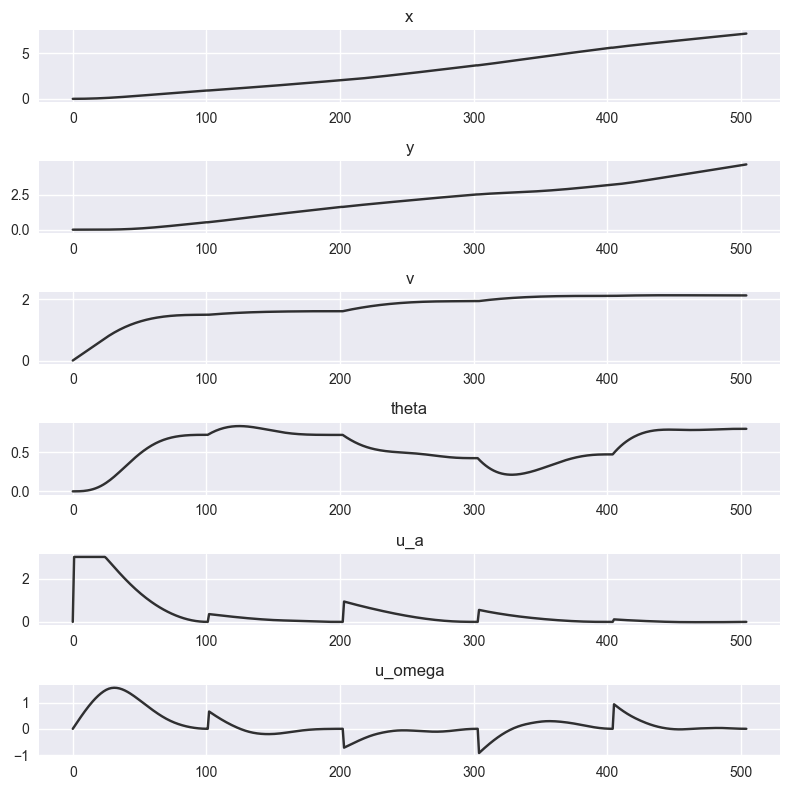

In [9]:
x_bars = np.hstack(x_bars)
y_bars = np.hstack(y_bars)
v_bars = np.hstack(v_bars)
theta_bars = np.hstack(theta_bars)
u_as = np.hstack(u_as)
u_omegas = np.hstack(u_omegas)

# Plot x_bars, y_bars, v_bars, theta_bars, u_as, u_omegas
fig, ax = plt.subplots(6, 1, figsize=(8, 8))

ax[0].plot(np.arange(len(x_bars)), x_bars, 'k-', alpha=0.8)
ax[0].set_title('x')

ax[1].plot(np.arange(len(x_bars)), y_bars, 'k-', alpha=0.8)
ax[1].set_title('y')

ax[2].plot(np.arange(len(x_bars)), v_bars, 'k-', alpha=0.8)
ax[2].set_title('v')

ax[3].plot(np.arange(len(x_bars)), theta_bars, 'k-', alpha=0.8)
ax[3].set_title('theta')

ax[4].plot(np.arange(len(x_bars)), u_as, 'k-', alpha=0.8)
ax[4].set_title('u_a')

ax[5].plot(np.arange(len(x_bars)), u_omegas, 'k-', alpha=0.8)
ax[5].set_title('u_omega')


plt.tight_layout()
plt.show()


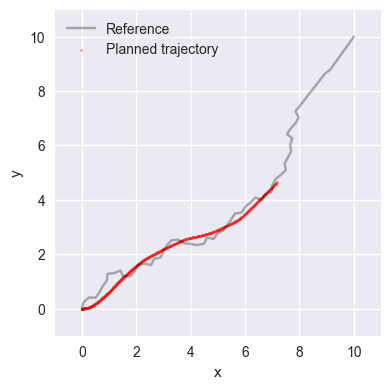

In [19]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Plot the reference
ax.plot(xs[:, 0], xs[:, 1], 'k-', alpha=0.3, label='Reference')

# Plot the path plotted to follow the local planner
ax.scatter(x_bars, y_bars, c='r', s=3, alpha=0.3, label='Planned trajectory')

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_xlim([-1, 11])
ax.set_ylim([-1, 11])
ax.set_aspect('equal', 'box')
ax.legend()

plt.tight_layout()
plt.show()
